<div align="center"><a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/Automatizacion/Extras/transcripts_youtube.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg'/> </a>

## Nube de Palabras de Youtube

En esta notebook, dada una url de una playlist de youtube, seguimos los siguientes pasos:
- Traer URLs de los videos
- Extraer el identificador del video de la URL
- Con el mismo, traer transcripciones disponibles, en español u otras
- Pequeño proceso para transformar los subtítulos en un texto concatenado
- Guardar, comprimir y descargar
- Finalmente: nube de palabras con los subtítulos de la playlist

In [ ]:
# Setup
%%capture
# Librería para bajar transcripts
!pip install youtube-transcript-api
# Para descargas de youtube en general
!pip install youtube-dl
# Herramienta bash para jsons
!sudo apt-get install jq

In [ ]:
# Playlist con los vids a transcribir
playlist_url = "https://www.youtube.com/watch?v=kmlYp8I1MJs&list=PLISuMnTdVU-xOHf3jEtiK1B_g5HFgXCb-"

In [ ]:
# Bash para listar usando youtube-dl
# los links a los videos de la playlist
# El comando de bash lo saqué de stackoverflow y adapté un poquito ;)
vid_urls = !youtube-dl -j --flat-playlist "$playlist_url" | jq -r '.id' | sed 's_^_https://youtu.be/_'
vid_urls

['https://youtu.be/kmlYp8I1MJs',
 'https://youtu.be/JB7H4htd3tU',
 'https://youtu.be/QpEuv_QHb8o',
 'https://youtu.be/z1uc8wdqSZA',
 'https://youtu.be/uXBnGLPE010',
 'https://youtu.be/v42ykY4iztE',
 'https://youtu.be/VV6UX_0xws4',
 'https://youtu.be/GiVsZhcWEu0',
 'https://youtu.be/1MucxZ5ajF0',
 'https://youtu.be/1ichChURnjM',
 'https://youtu.be/iWloasRpleU']

In [ ]:
# Extramos ids de los videos
ids = [url.split('/')[-1] for url in vid_urls]
ids

['kmlYp8I1MJs',
 'JB7H4htd3tU',
 'QpEuv_QHb8o',
 'z1uc8wdqSZA',
 'uXBnGLPE010',
 'v42ykY4iztE',
 'VV6UX_0xws4',
 'GiVsZhcWEu0',
 '1MucxZ5ajF0',
 '1ichChURnjM',
 'iWloasRpleU']

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

In [ ]:
def process_transcript(transcript: list, th = 1):
  """
  El transcript se descarga como una lista de dicts con la siguiente forma

    [{'duration': 2.312,
      'start': 0.532,
      'text': 'hola como va'},
    ...

  Esta funcion concatena los textos, y agrega un punto y paso de linea
  si entre el final de un texto y el comienzo del siguiente hay mas de th 
  segundos.
  Devuelve texto completo.
  """
  full = ''
  t_0 = transcript[0]
  for i in range(1, len(transcript)):
    t = transcript[i]
    full += t['text'].strip() +' '
    if t['start'] > t_0['start'] + t_0['duration'] + th:
      full += '.\n'
    t_0 = t
  return full

In [ ]:
# Para cada id, descargamos, procesamos y guardamos
idioma = 'es'
for i, id in enumerate(ids):
  raw_transcript = YouTubeTranscriptApi.get_transcript(id, languages=(idioma,))
  text = process_transcript(raw_transcript)
  with open(f"{str(i)}.txt", "w") as out:
    out.write(text)

In [ ]:
# Guardamos todos los txt en un zip
import glob, zipfile

with zipfile.ZipFile('transcripts.zip', 'w') as zip:
    for f in glob.glob('*.txt'):
        zip.write(f)

In [ ]:
# Descargamos
from google.colab import files
files.download('transcripts.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Nube de palabras

In [33]:
import glob
texts = [open(t).read() for t in glob.glob('*.txt')]

In [40]:
# Tengamos en cuenta que en la transcripción automática faltan muchas palabras técnicas
palabras = ['pyautogui', 'requests', 'xpath', 'python']
any(p in texto for p in palabras)

False

In [51]:
from wordcloud import ImageColorGenerator, WordCloud
from PIL import Image
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

def make_cloud(text, stopwords=[], 
               img_url=None, 
               width=1000, 
               height=1000, 
               plot=True, 
               min_font_size=10, 
               bg_color='white'):

  mask = None
  if img_url:
      mask = np.array(Image.open(BytesIO(rq.get(img_url).content)))
      mask[mask > 250] = 255
      image_colors = ImageColorGenerator(mask)
      width = mask.shape[1]
      height = mask.shape[0]

  wordcloud = WordCloud(
      width=width,
      height=height,
      background_color=bg_color,
      stopwords=stopwords,
      random_state=42,
      min_font_size=min_font_size,
      mask=mask,
      color_func=image_colors if img_url else None,
      margin=0,
  ).generate(text)

  if plot:
      plt.figure(figsize=(6, 6))
      plt.imshow(wordcloud)
      plt.axis("off")
      plt.tight_layout(pad=0)
      plt.show()

  return wordcloud

# Para uso de StopWords, ver clase de Intro a NLP
stop_words = nltk.corpus.stopwords.words('spanish')
stop_words2 = rq.get('https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt').text.split('\n')
stop_words = set(stop_words+stop_words2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


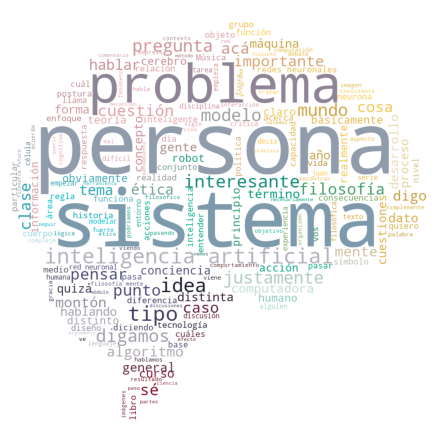

In [52]:
texto = ' '.join(texts)
img_url = "https://toppng.com/uploads/preview/human-brain-png-high-quality-image-brain-clipart-115630224411rqb2dvotv.png"
make_cloud(texto, stopwords=stop_words, img_url=img_url);